In [2]:
import pandas as pd
import tensorflow as tf
import numpy
import pickle as pkl
import os
os.chdir(os.path.join(os.getcwd(), ".."))
import finviz as fz
import yfinance as yf
import calendar
import datetime
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc, average_precision_score, log_loss
#from sklearn.metrics import PrecisionRecallDisplay

from src.utils import data_layer, get_dataset, hist_multi_plot

%load_ext autoreload
%autoreload 2

In [3]:
perc_space = 0.8
perc_time = 0.8

WINDOW_SIZE = 21 # Include window + target
BATCH_SIZE = 32

data_path = os.path.join(os.getcwd(), "data")
sp_100_file = os.path.join(data_path, "sp-100-index-07-02-2020.csv")

# Load and Data formatting

In [4]:
stock = data_layer(sp_100_file, data_path, perc_space, perc_time)

BKNG <class 'IndexError'> list index out of range
BRK.B <class 'requests.exceptions.HTTPError'> 404 Client Error: Not Found for url: https://finviz.com/quote.ashx?t=BRK.B
C <class 'IndexError'> list index out of range
DD <class 'IndexError'> list index out of range
EXC <class 'IndexError'> list index out of range
GOOGL <class 'IndexError'> list index out of range
GS <class 'IndexError'> list index out of range
MO <class 'IndexError'> list index out of range
RTX <class 'IndexError'> list index out of range


In [1]:
stock['AAPL'].head()

NameError: name 'stock' is not defined

In [5]:
n_train_space = int(len(stock.keys())*perc_space)
n_train_out_space = len(stock.keys())-n_train_space

In [6]:
train_space = np.random.choice(list(stock.keys()), size=n_train_space, replace=False).tolist()
test_space = list(set(stock.keys()) - set(train_space))
samples = stock["AAPL"].shape[0]
train_samples = int((samples-WINDOW_SIZE)*perc_time)

# Data loader object

In [7]:
train_ds, val_ds = get_dataset(stock, train_space, train_samples=train_samples, window_size=WINDOW_SIZE)

Companies:  ['CVX', 'ALL', 'MDT', 'FB', 'BAC', 'SPG', 'XOM', 'FDX', 'JNJ', 'MDLZ', 'ABT', 'MS', 'IBM', 'COST', 'LMT', 'UNP', 'MRK', 'GM', 'DOW', 'ABBV', 'PG', 'WMT', 'PYPL', 'NKE', 'CMCSA', 'BIIB', 'KO', 'SO', 'PFE', 'HON', 'TMO', 'CVS', 'NEE', 'INTC', 'F', 'VZ', 'UNH', 'USB', 'GILD', 'CRM', 'MSFT', 'COP', 'NFLX', 'WBA', 'AAPL', 'KMI', 'CL', 'ADBE', 'MET', 'AXP', 'AIG', 'BLK', 'TGT', 'NVDA', 'WFC', 'MA', 'HD', 'KHC', 'DIS', 'TXN', 'GE', 'GD', 'OXY', 'DUK', 'MMM', 'CSCO', 'QCOM', 'DHR', 'AMGN', 'JPM', 'LLY', 'LOW', 'ORCL']


In [8]:
test_ds = get_dataset(stock, test_space, train_samples=None, window_size=WINDOW_SIZE)

Companies:  ['CAT', 'CHTR', 'COF', 'BK', 'GOOG', 'PEP', 'PM', 'ACN', 'AMT', 'V', 'T', 'AMZN', 'UPS', 'BMY', 'SLB', 'BA', 'MCD', 'SBUX', 'EMR']


In [9]:
train_ds = train_ds.shuffle(buffer_size=8000)
train_ds = train_ds.batch(BATCH_SIZE)
train_ds = train_ds.prefetch(16)
val_ds = val_ds.batch(BATCH_SIZE)
test_ds = test_ds.batch(BATCH_SIZE)

# Model

In [34]:
class Encoder(tf.keras.Model):
    
        def __init__(self, conv1_params, conv2_params):
            """Initialization of the two convoutional layers that compose the model.
            It receives two dicts with the parameters of the 1D convolution layers.
            To be consistent with the TCNN implementation, the padding of the
            convolutions must be 'causal' and the dilation_rate argument
            must be provided for each layer.
            Parameters
            ----------
            conv1_params : dict
                The parameters for the first convolutional layer of the residual block of the TCNN
            conv2_params : dict
                The parameters for the second convolutional layer of the residual block of the TCNN
            """
            super(Encoder, self).__init__()
            self.conv1 = tf.keras.layers.Conv1D(**conv1_params)
            self.bn1 = tf.keras.layers.BatchNormalization()
            self.conv2 = tf.keras.layers.Conv1D(**conv2_params)
            self.bn2 = tf.keras.layers.BatchNormalization()
            self.relu  = tf.keras.layers.ReLU() 
            self.relu_1 = tf.keras.layers.ReLU()
    
        def call(self, x):
            aux_int = self.conv1(x)
            aux_int = self.bn1(aux_int)
            res_1 = self.relu_1(aux_int)
            aux_int = self.conv2(res_1)
            out_2 = self.bn2(aux_int)
            y = tf.add(out_2 , x)
            y = self.relu(y)
            return y

In [35]:
class Decoder(tf.keras.Model):
    
        def __init__(self, units_1, units_2):
            """Initialization of the two convoutional layers that compose the model.
            It receives two dicts with the parameters of the 1D convolution layers.
            To be consistent with the TCNN implementation, the padding of the
            convolutions must be 'causal' and the dilation_rate argument
            must be provided for each layer.
            Parameters
            ----------
            conv1_params : dict
                The parameters for the first convolutional layer of the residual block of the TCNN
            conv2_params : dict
                The parameters for the second convolutional layer of the residual block of the TCNN
            """
            super(Decoder, self).__init__()
            self.dense1 = tf.keras.layers.Dense(units_1)
            self.bn1 = tf.keras.layers.BatchNormalization()
            self.relu = tf.keras.layers.ReLU()
            self.dense2 = tf.keras.layers.Dense(units_2)
            self.bn2 = tf.keras.layers.BatchNormalization()
    
        def call(self, x):
            aux_int = self.dense1(x)
            aux_int = self.bn1(aux_int)
            res_1 = self.relu(aux_int)
            aux_int = self.dense2(res_1)
            y = self.bn2(aux_int)
            return y

In [39]:
class TCNN(tf.keras.Model):
    """This is the implementation of the TCNN model according to the paper Probabilistic Forecasting
    with Temporal Convolutional Neural Network [https://arxiv.org/pdf/1906.04397.pdf]. There are two
    minor changes here in the decoder; First, we apply a neural network to the encoder vector and
    compute the prediction for the future "w" days (Decoder 1) and then we compute the deviation
    for each day using the exogenous variables (Decoder 2). It is important to highlight that de
    Decoder 1 network has different parameters for each day prediction but the Decoder 2 share
    parameters between days.
    """
    def __init__(self, encoder_params, decoder1_dims):
        """Model initialization
        Parameters
        ----------
        encoder_params : List[Dict]
            A list formed by convolution_parameters dictionaries to instantiate
            the encoder of the model. Each dict contains the information of a Conv1d layer.
        decoder1_dims : List[Int]
            A list with the dims of the decoder 1 Dense layers.
        decoder2_dims : List[Int]
            A list with the dims of the decoder 2 Dense layers.
        n_channels_enc : int
            The number of channels in the encoder.
        """
        super(TCNN, self).__init__()
        self.variable_range = 2
        #encoder
        self.encoders = []
        for i in range(0,len(encoder_params),2):
            encoder = Encoder(encoder_params[i],encoder_params[i + 1])
            self.encoders.append(encoder)
        #emebeddings
        self.embedding_buy = tf.keras.layers.Embedding(input_dim=self.variable_range, output_dim=1)
        self.embedding_sell = tf.keras.layers.Embedding(input_dim=self.variable_range, output_dim=1)
        self.embedding_option = tf.keras.layers.Embedding(input_dim=self.variable_range, output_dim=1)
        
        self.flatten = tf.keras.layers.Flatten()
        #Decoder
        self.decoder = Decoder(256,256)
        
        
        self.Decoder1_dense1 = tf.keras.layers.Dense(decoder1_dims[0], activation='relu')  # input 256
        self.Decoder1_dense2 = tf.keras.layers.Dense(decoder1_dims[1])  # input timesteps_target
        self.sigmoids = tf.keras.layers.Dense(3, activation="sigmoid")
        
    def call(self, input_tensor):
        """A Pass of the input tensor through the model
        Parameters
        ----------
        input_tensor : Tuple[tf.Tensor]
            A tuple with all the information required to compute a pass through the model.
            input_tensor[0]: The input time series tf.Tensor (Batch_size, input_seq_length,
                                                              n_channels_encoder - n_covariates)
            input_tensor[1]: The input time series days tf.Tensor (Batch_size, input_seq_length)
            input_tensor[2]: The input time series hours tf.Tensor (Batch_size, input_seq_length,
                                                              1)
            input_tensor[3]: The input time series month tf.Tensor (Batch_size, input_seq_length,
                                                              1)
            input_tensor[4]: The output time series days tf.Tensor (Batch_size, output_seq_length,
                                                              1)
            input_tensor[5]: The output time series hours tf.Tensor (Batch_size, output_seq_length,
                                                              1)
            input_tensor[6]: The output time series month tf.Tensor (Batch_size, output_seq_length,
                                                              1)
        Returns
        -------
        tf.Tensor (Batch_size, output_seq_length, 1)
        """
        
        input_t , today_info = input_tensor
        
        buy_emb =  self.embedding_buy(input_t[:,:,-3])
        option_emb = self.embedding_sell(input_t[:,:,-2])
        sell_emb = self.embedding_option(input_t[:,:,-1])
        input_with_emb = tf.concat([input_t[:,:,:-3], buy_emb, option_emb, sell_emb], axis= -1)
        encoder_tensor = input_with_emb
        for encoder in self.encoders:
            encoder_tensor = encoder(encoder_tensor)
        enc_output = self.flatten(encoder_tensor[:, -1:, :])
        dec_output = self.decoder(today_info)
        
        output = tf.concat([enc_output,dec_output], axis = -1)
        
        output = self.Decoder1_dense1(output)        
        outputs = self.sigmoids (output)
        outputs = tf.keras.backend.expand_dims(outputs, axis=1)
        return outputs




In [21]:
dilation_rates=[1,1,2,2,4,4,7,7]
kernel_size=7
number_features=15

In [14]:
enc_convolution_params = []
for idx, dilation_rate in enumerate(dilation_rates):
    conv_params = dict()
    if idx == 0:
        conv_params["input_shape"] = (WINDOW_SIZE, 5)
    conv_params["filters"] = number_features
    conv_params["kernel_size"] = kernel_size
    conv_params["padding"] = "causal"
    conv_params["dilation_rate"] = dilation_rate
    enc_convolution_params.append(conv_params)

In [72]:
model = TCNN(enc_convolution_params, [256,1])

In [23]:
x = next(iter(train_ds))

In [41]:
model(x[0])


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



<tf.Tensor: shape=(32, 1, 3), dtype=float32, numpy=
array([[[1., 1., 0.]],

       [[1., 1., 0.]],

       [[1., 1., 0.]],

       [[1., 1., 0.]],

       [[0., 1., 0.]],

       [[1., 1., 0.]],

       [[1., 1., 0.]],

       [[0., 1., 0.]],

       [[0., 1., 0.]],

       [[1., 1., 0.]],

       [[0., 1., 0.]],

       [[0., 1., 0.]],

       [[0., 1., 0.]],

       [[1., 1., 0.]],

       [[1., 1., 0.]],

       [[1., 1., 0.]],

       [[0., 1., 0.]],

       [[1., 1., 0.]],

       [[1., 1., 0.]],

       [[1., 1., 0.]],

       [[0., 1., 0.]],

       [[1., 1., 0.]],

       [[0., 1., 0.]],

       [[1., 1., 0.]],

       [[0., 1., 0.]],

       [[1., 1., 0.]],

       [[1., 0., 1.]],

       [[1., 1., 0.]],

       [[0., 1., 0.]],

       [[1., 1., 0.]],

       [[1., 1., 0.]],

       [[0., 1., 0.]]], dtype=float32)>

In [73]:
model.compile(loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy", "AUC", tf.keras.metrics.AUC(curve="PR", name="PR_AUC")])
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', #val_loss
                                               patience=8,
                                               mode='min',
                                               restore_best_weights=True)

In [74]:
history = model.fit(train_ds, 
                    validation_data=val_ds,
                    epochs=100, 
                    callbacks = [es_callback])

Epoch 1/100
420/420 [==============================] - 13s 31ms/step - loss: 6.3192 - accuracy: 0.5858 - AUC: 0.3995 - PR_AUC: 0.0224 - val_loss: 5.5156 - val_accuracy: 0.6398 - val_AUC: 0.3439 - val_PR_AUC: 0.0196
Epoch 2/100
420/420 [==============================] - 9s 21ms/step - loss: 5.4440 - accuracy: 0.6433 - AUC: 0.3802 - PR_AUC: 0.0213 - val_loss: 5.5156 - val_accuracy: 0.6398 - val_AUC: 0.3439 - val_PR_AUC: 0.0196
Epoch 3/100
420/420 [==============================] - 9s 21ms/step - loss: 5.4436 - accuracy: 0.6433 - AUC: 0.3802 - PR_AUC: 0.0213 - val_loss: 5.5156 - val_accuracy: 0.6398 - val_AUC: 0.3439 - val_PR_AUC: 0.0196
Epoch 4/100
420/420 [==============================] - 8s 20ms/step - loss: 5.4440 - accuracy: 0.6433 - AUC: 0.3802 - PR_AUC: 0.0213 - val_loss: 5.5156 - val_accuracy: 0.6398 - val_AUC: 0.3439 - val_PR_AUC: 0.0196
Epoch 5/100
420/420 [==============================] - 10s 23ms/step - loss: 5.4441 - accuracy: 0.6433 - AUC: 0.3802 - PR_AUC: 0.0213 - val_los

In [30]:
model.evaluate(test_ds)

    139/Unknown - 1s 5ms/step - loss: 894.6779 - accuracy: 0.9728 - AUC: 0.5281 - PR_AUC: 0.0304

[894.677875697864, 0.9728185, 0.52809566, 0.030415446]

# Comparing predictions and looking if it is learning anything
dataframe start from the 20, example df[20:] are all the samples in test, and each company has ~232 records, so to iterate would be accooording to 232 and addding 20 to the origiinal df

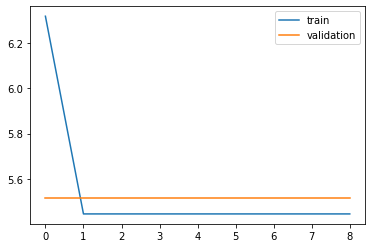

In [75]:
plt.plot(history.history['loss'],  label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()

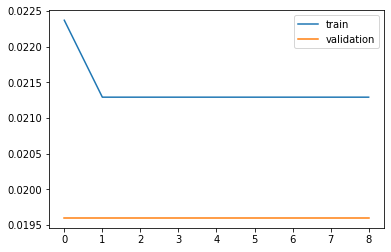

In [76]:
plt.plot(history.history['PR_AUC'], label='train')
plt.plot(history.history['val_PR_AUC'], label='validation')
plt.legend()

In [50]:
y_test = []
for sample in test_ds:
    y_test.append(sample[1].numpy())
y_test = np.squeeze(np.concatenate(y_test))

In [51]:
y_test

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       ...,
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [77]:
out = model.predict(test_ds)
out = np.squeeze(out)
aux_stock = {}
cont = 0
for idx, company in enumerate(test_space):
    print("Company: ", company)
    curr_hist = stock[company]
    curr_index = curr_hist.index[WINDOW_SIZE-1:]
    curr_size = len(curr_index)
    pred_df = pd.DataFrame(out[cont:cont+curr_size],
                           index=curr_hist.index[WINDOW_SIZE-1:],
                           columns=["Pred_Buy", "Pred_Option", "Pred_Sale"])
    aux_stock[company] = stock[company].merge(pred_df, how="left", 
                                              left_index=True, right_index=True)
    cont = cont + curr_size

Company:  CAT
Company:  CHTR
Company:  COF
Company:  BK
Company:  GOOG
Company:  PEP
Company:  PM
Company:  ACN
Company:  AMT
Company:  V
Company:  T
Company:  AMZN
Company:  UPS
Company:  BMY
Company:  SLB
Company:  BA
Company:  MCD
Company:  SBUX
Company:  EMR


0.0

In [78]:
df = pd.DataFrame(np.concatenate([out, y_test], axis=1), 
             columns=["pred_Buy", "pred_Option", "pred_Sale", "Buy", "Option", "Sale"])

In [59]:
df.head()

,pred_Buy,pred_Option,pred_Sale,Buy,Option,Sale
0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
means = df.mean()

# Metrics

/Users/santiagocortes/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/numpy/lib/histograms.py:898: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


Average Precision:  0.004310344827586207
Binary Crossentropy 34.39069850961528


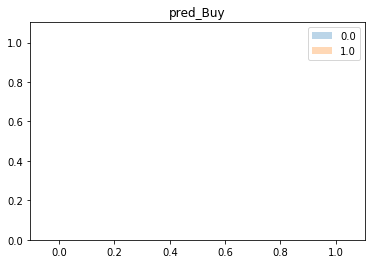

In [79]:
pred_col = "pred_Buy"
col = "Buy"
hist_multi_plot(df, pred_col, col, bins=np.arange(0,1, 0.01))
precision, recall, _ = precision_recall_curve(df[col], df[pred_col])
#pr_display = PrecisionRecallDisplay(precision=precision, recall=recall).plot()
average_precision_buy = average_precision_score(df[col], df[pred_col])
print("Average Precision: ", average_precision_buy)
#strawman_ce = log_loss(df[col], np.ones(df[col].shape)*means[col])
#print("Strawman Crossentropy", strawman_ce)
bce = log_loss(df[col], df[pred_col])
print("Binary Crossentropy", bce)

/Users/santiagocortes/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/numpy/lib/histograms.py:898: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


Average Precision:  0.02472776769509982
Binary Crossentropy 0.8540668391663494


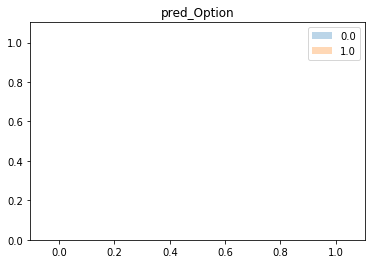

In [80]:
pred_col = "pred_Option"
col = "Option"
hist_multi_plot(df, pred_col, col, bins=np.arange(0,1, 0.01))
precision, recall, _ = precision_recall_curve(df[col], df[pred_col])
#pr_display = PrecisionRecallDisplay(precision=precision, recall=recall).plot()
average_precision_op = average_precision_score(df[col], df[pred_col])
print("Average Precision: ", average_precision_op)
#strawman_ce = log_loss(df[col], np.ones(df[col].shape)*means[col])
#print("Strawman Crossentropy", strawman_ce)
bce = log_loss(df[col], df[pred_col])
print("Binary Crossentropy", bce)

/Users/santiagocortes/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/numpy/lib/histograms.py:898: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


Average Precision:  0.052177858439201454
Binary Crossentropy 1.8021593853968831


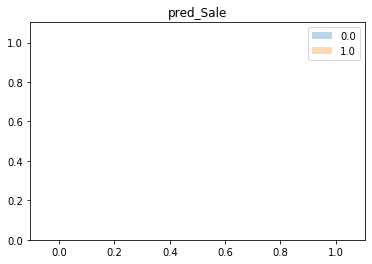

In [81]:
pred_col = "pred_Sale"
col = "Sale"
hist_multi_plot(df, pred_col, col, bins=np.arange(0,1, 0.01))
precision, recall, _ = precision_recall_curve(df[col], df[pred_col])
#pr_display = PrecisionRecallDisplay(precision=precision, recall=recall).plot()
average_precision_sale = average_precision_score(df[col], df[pred_col])
print("Average Precision: ", average_precision_sale)
#strawman_ce = log_loss(df[col], np.ones(df[col].shape)*means[col])
#print("Strawman Crossentropy", strawman_ce)
bce = log_loss(df[col], df[pred_col])
print("Binary Crossentropy", bce)

In [82]:
sum([average_precision_sale, average_precision_op,average_precision_buy])/3

0.027071990320629156